In [149]:
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as plt
import random
import scipy.stats as st
import time
import pickle as pkl
import importlib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from phase_analysis import phase_analysis
from phase_analysis import phase_processor
from python_pattern_stim_analysis import PGanalysis

In [255]:
importlib.reload(PGanalysis)

<module 'python_pattern_stim_analysis.PGanalysis' from 'C:\\Users\\rmb55\\virtual_environments\\pattern-stim3\\lib\\site-packages\\python_pattern_stim_analysis\\PGanalysis.py'>

In [277]:
# set the target directory for figure 1 phase experiment data 
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_stats')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_stats'

In [278]:
### First, lets plot some rasters of example stimulation-phase-tuned cells 
raster_array_path  = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\raster_data\230407.npy'
psth_path = r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\paper\data\230407.npy'
mtrigger_path =  r'Z:\robin\expt_sets\pattern_stim\recordings\230407\2023-04-07_14-57-28\experiment1\recording1\continuous\Rhythm_FPGA-100.0\230407_mtrigger.dat'
expt_metadata_path = r'Z:\robin\expt_sets\pattern_stim\metadata\230407\P162_2023_4_7_17253_fullexpt'
hilbert_transformed_resp_path = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\resp_data\230407.npy'

In [4]:
start = time.time()
trial_type_raster_array = np.load(raster_array_path, allow_pickle = True)
mtrigger_array = PGanalysis.get_events(mtrigger_path)
hilbert_transformed_resp_array = np.load(hilbert_transformed_resp_path, allow_pickle = True)
with open(expt_metadata_path, 'rb') as f:
    expt_metadata = pkl.load(f)
end = time.time()
print(start-end)

-32.95509910583496


In [5]:
mtrigger_array = PGanalysis.get_events(mtrigger_path)
hilbert_transformed_resp_array = np.load(hilbert_transformed_resp_path, allow_pickle = True)
with open(expt_metadata_path, 'rb') as f:
    expt_metadata = pkl.load(f)

In [6]:
trial_type_indices = phase_analysis.get_trial_type_indices(expt_metadata)
frame_on_time_s = phase_analysis.get_frame_on_time_s(mtrigger_array)
bin_indices_all, bins = phase_analysis.get_bin_indices(trial_type_indices, expt_metadata, frame_on_time_s, hilbert_transformed_resp_array,  bin_width = 36)

In [ ]:
importlib.reload(phase_analysis)

In [36]:
trial_type_psth_array = np.load(psth_path, allow_pickle = True)

In [4]:
trial_type_psth_array.shape

(123, 11, 2000, 1500)

In [50]:
'''Plot PSTHs for each cell for each phase bin.'''
def plot_phase_binned_PSTHs(cell, stim, trial_type_psth_array, bin_indices_all, bins, x):
    plt.figure(figsize = (20,10))
    for bin_num in range(1,len(bins)):
        cell_stim_psth = trial_type_psth_array[cell,stim]
        phase_binned_psth = []
        for i, trial in enumerate(cell_stim_psth): 
            if i in np.where(bin_indices_all[stim] == bin_num)[0]:
                phase_binned_psth.append(trial)
        plt.subplot(4,5,bin_num)
        plt.plot(x, np.mean(phase_binned_psth,0), linewidth = 2, color = 'k');
        plt.xlim(-.5,.5)
        plt.xticks(np.arange(-.5,.75,.25))
        plt.title(str(np.degrees(bins[bin_num])))
        plt.ylabel('trial')
        plt.xlabel('time since stim (s)')
        plt.ylim(0,30)
        PGanalysis.axis_fixer(ratio = .5, size = 10)
    PGanalysis.axis_fixer(ratio = .5, size = 10)

meta NOT subset; don't know how to subset; dropped


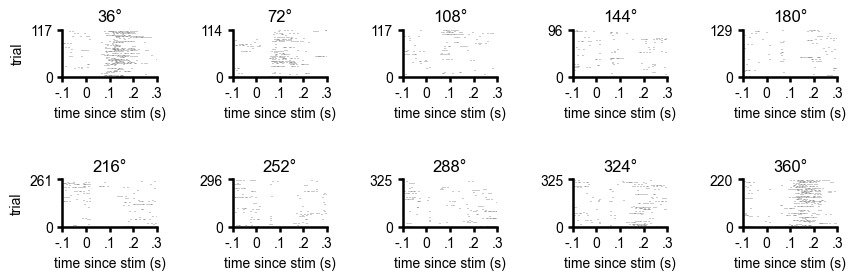

In [257]:
cell = 13
stim = 1
phase_analysis.plot_phase_binned_rasters(trial_type_raster_array, bin_indices_all, cell, stim)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\example_rasters_cell13_stim1.pdf', bbox_inches = 'tight')

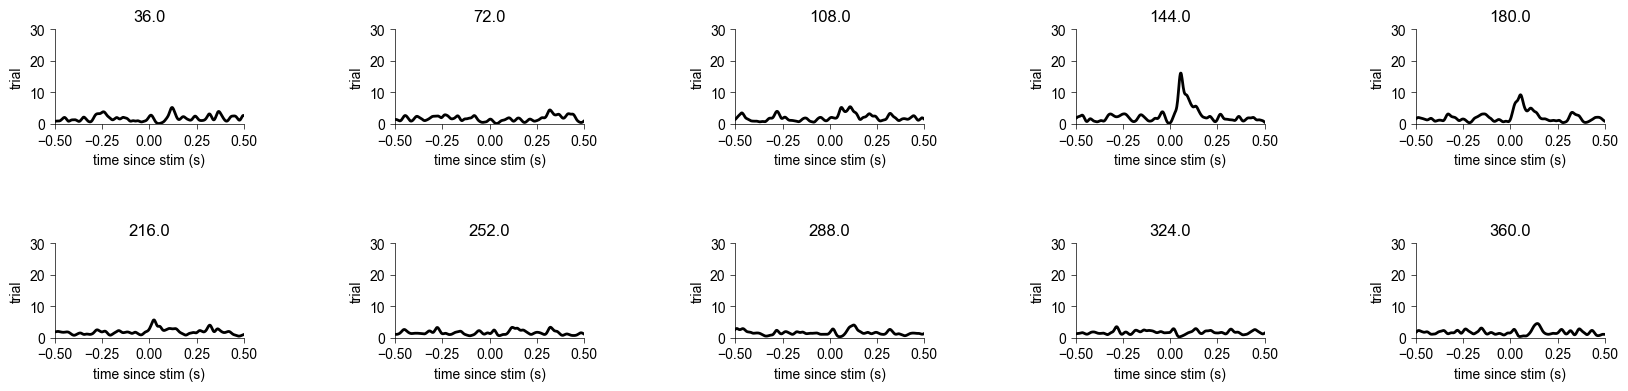

In [59]:
x = np.arange(-1,2,.002)
plot_phase_binned_PSTHs(70,8,trial_type_psth_array, bin_indices_all, bins, x)

meta NOT subset; don't know how to subset; dropped


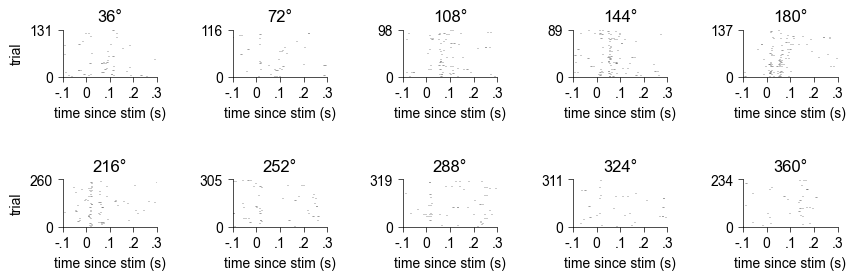

In [119]:
cell = 70
stim = 5
phase_analysis.plot_phase_binned_rasters(trial_type_raster_array, bin_indices_all, cell, stim)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\example_rasters_cell70_stim5.pdf', bbox_inches = 'tight')

### Next, lets quantify the proportion of cells that exhibit this stimulation-phase-tuning. 

### first, we will load the phase stats data

In [279]:
# load the phase experiment data dictionaries 
all_phase_expts = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    all_phase_expts.append(phase_expt)

In [280]:
# concatenate this set of fields using the dict_key_concatenator. We will use these concatenated fields in later analyses. 
dict_keys = ['Kruskal_pval_thresh', 'Mann_Whitney_responsive_cell_bins', 'all_stim_resp_pref_phase', 'all_stim_time_to_50', 'stimulation_phase_preference']
concat_dict = {}
for key in dict_keys:
    concat_dict[key] = phase_analysis.dict_key_concatenator(all_phase_expts, key)

In [281]:
stimulation_phase_preference = concat_dict['stimulation_phase_preference']
all_stim_rise_times = concat_dict['all_stim_time_to_50']
all_stim_resp_pref_phase = concat_dict['all_stim_resp_pref_phase']

In [282]:
# calculation proportion of cells significantly activated by each spot
all_spot_activated = []
for expt in all_phase_expts: 
    # for each cell, for each spot, get the number of bins in which the cell is significantly activated.
    stim_activated_thresh = np.sum(expt['Mann_Whitney_responsive_cell_bins']['activated'],1)
    n_stim = expt['Kruskal_pval_thresh'].shape[0]
    for stim in range(n_stim):
        if stim>0:
            # for each spot, if there is a bin in which the cell is significantly activated, count the cell as activated by that spot.
            activated_count = len(np.where((stim_activated_thresh[stim,:]>0))[0])
            all_count = len(stim_activated_thresh[stim,:])
            # calculate the proportion of cells that are significantly activated by each spot. 
            all_spot_activated.append((activated_count/all_count)*100)

### determine what percentage of significantly activated cells are tuned to stimulation phase

In [156]:
all_spot_tuned_total = []
all_spot_tuned_responsive = []
for expt in all_phase_expts: 
    # for each cell, for each spot, get the number of bins in which the cell is significantly activated.
    stim_activated_thresh = np.sum(expt['Mann_Whitney_responsive_cell_bins']['activated'],1)
    n_stim = expt['Kruskal_pval_thresh'].shape[0]
    for stim in range(n_stim):
        if stim>0:
            # count cells that are both significantly activated and significantly tuned. 
            activated_tuned_count = len(np.where((expt['Kruskal_pval_thresh'][stim,:]>0)&(stim_activated_thresh[stim,:]>0))[0])
            all_count = len((stim_activated_thresh[stim,:]>0))
            all_activated = len(np.where(stim_activated_thresh[stim,:]>0)[0])
            # get the percentage of total cells that are both activated and tuned
            all_spot_tuned_total.append((activated_tuned_count/all_count)*100)
            # get the percentage of significantly activated cells that are tuned. 
            all_spot_tuned_responsive.append((activated_tuned_count/all_activated)*100)

meta NOT subset; don't know how to subset; dropped


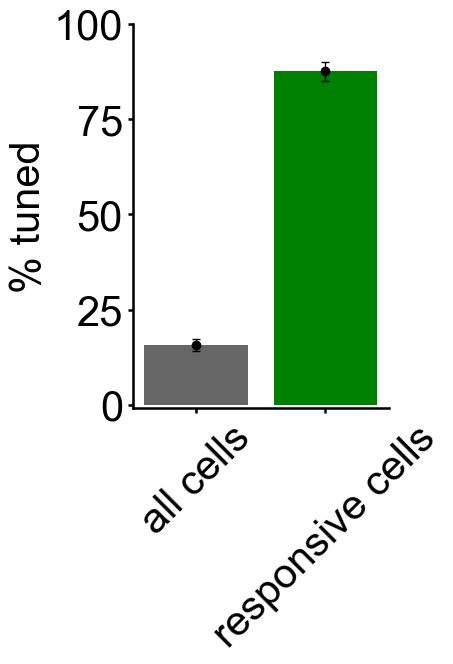

In [259]:
# plot percentage of significantly activated cells (mann whitney U p < .0025) that are tuned (kruskal-wallis p<.01)
color = [[.4,.4,.4],'g']
plt.bar([0,1], [np.mean(all_spot_tuned_total), np.mean(all_spot_tuned_responsive)], color = color)
plt.ylim(-1,100)
plt.yticks([0,25,50,75,100])
plt.ylabel('% tuned')
CI_total = np.mean(all_spot_tuned_total) -st.t.interval(alpha=0.95, df=len(all_spot_tuned_total)-1, loc=np.mean(all_spot_tuned_total), scale=st.sem(all_spot_tuned_total))[0]
CI_responsive = np.mean(all_spot_tuned_responsive) -st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive)-1, loc=np.mean(all_spot_tuned_responsive), scale=st.sem(all_spot_tuned_responsive))[0]
plt.xticks([0,1], labels = ['all cells', 'responsive cells'], rotation = 45)
plt.errorbar([0,1], [np.mean(all_spot_tuned_total), np.mean(all_spot_tuned_responsive)], yerr = [CI_total, CI_responsive], fmt = 'o', capsize = 3, elinewidth = 1, capthick = 1, linewidth = .5, color= 'k')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\percent_cells_tuned.pdf', bbox_inches = 'tight')

In [158]:
print('Mean proportion of cells significantly activated by a given spot in at least one bin = ' + str(np.mean(all_spot_activated)))
CI = st.t.interval(alpha=0.95, df=len(all_spot_activated)-1, loc=np.mean(all_spot_activated), scale=st.sem(all_spot_activated))
print('95% confidence interval = ' + str(np.mean(all_spot_activated) - CI[0]))

Mean proportion of cells significantly activated by a given spot in at least one bin = 17.949019242343358
95% confidence interval = 1.7177511587573768


In [159]:
print('Mean percentage of all responsive cells that are tuned = ' + str(np.mean(all_spot_tuned_responsive)))
CI = st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive)-1, loc=np.mean(all_spot_tuned_responsive), scale=st.sem(all_spot_tuned_responsive)) 
print('95% confidence interval = ' + str(np.mean(all_spot_tuned_responsive) - CI[0]))

Mean percentage of all responsive cells that are tuned = 87.61345718628384
95% confidence interval = 2.526080558762004


#### **1d:** Same example cells as in 1b, show temporal tuning curves across spots

In [17]:
tuning = np.load(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_tuning\230407.npy', allow_pickle = True)[0]

meta NOT subset; don't know how to subset; dropped


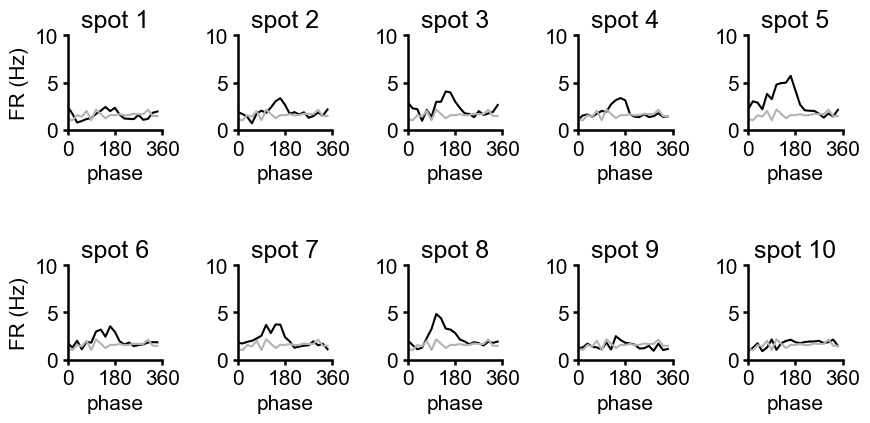

In [262]:
cell = 70
phase_analysis.plot_spot_tuning_curves(tuning, cell, ylim = 10)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\all_spot_tuning_curves_cell70.pdf', bbox_inches = 'tight')

In [787]:
all_phase_tuning_concat.shape

(11, 20, 519)

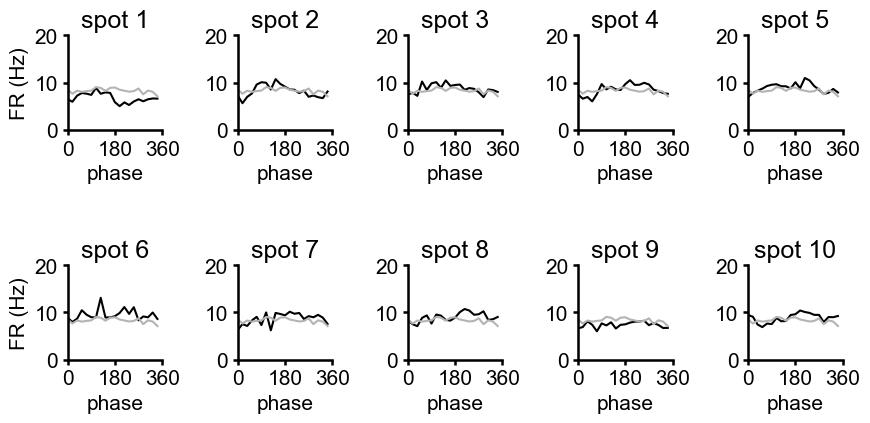

In [788]:
cell = 518
phase_analysis.plot_spot_tuning_curves(all_phase_tuning_concat, cell, ylim=20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\all_spot_tuning_curves_cell13.pdf', bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


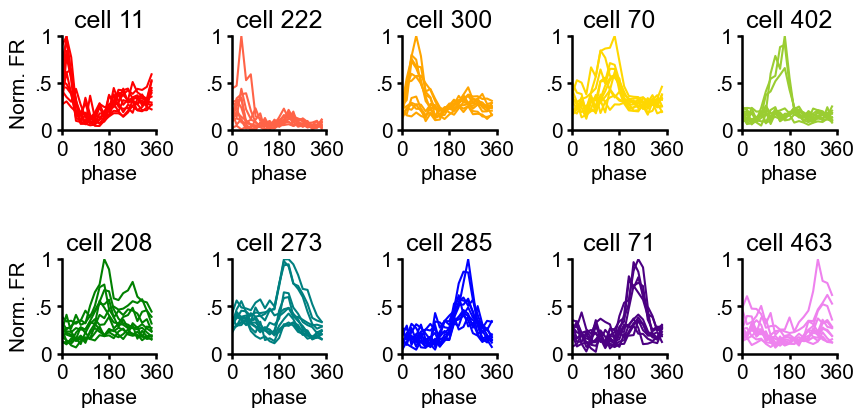

In [812]:
plt.figure(figsize = (10,30))
cells = [11,222,300,70,402,208,273,285,71,463]
colors = ['red', 'tomato','orange','gold','yellowgreen','green','teal','blue','indigo','violet']
phases = np.arange(0,360,18)
for cell_n, cell in enumerate(cells):
    plt.subplot(11,5,cell_n+1)
    for stim in range(all_phase_tuning_concat.shape[0]):
        plt.plot(phases,all_phase_tuning_concat[stim,:,cell]/np.max(all_phase_tuning_concat[:,:,cell]),color = colors[cell_n])
    #plt.plot(phases,tuning[0,:,cell]/np.max(tuning[:,:,cell]),color = 'k')
    plt.ylim(0,1)
    plt.xlim(0,360)
    plt.xticks([0,180,360])
    plt.yticks([0,.5,1], labels = ['0','.5','1'])
    plt.title('cell ' + str(cell))
    plt.xlabel('phase')
    if (cell_n == 0) or (cell_n == 5):
        plt.ylabel('Norm. FR')
    PGanalysis.axis_fixer(ratio = 1, size = 15)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\example_tuned_cells_rainbow.pdf', bbox_inches = 'tight')

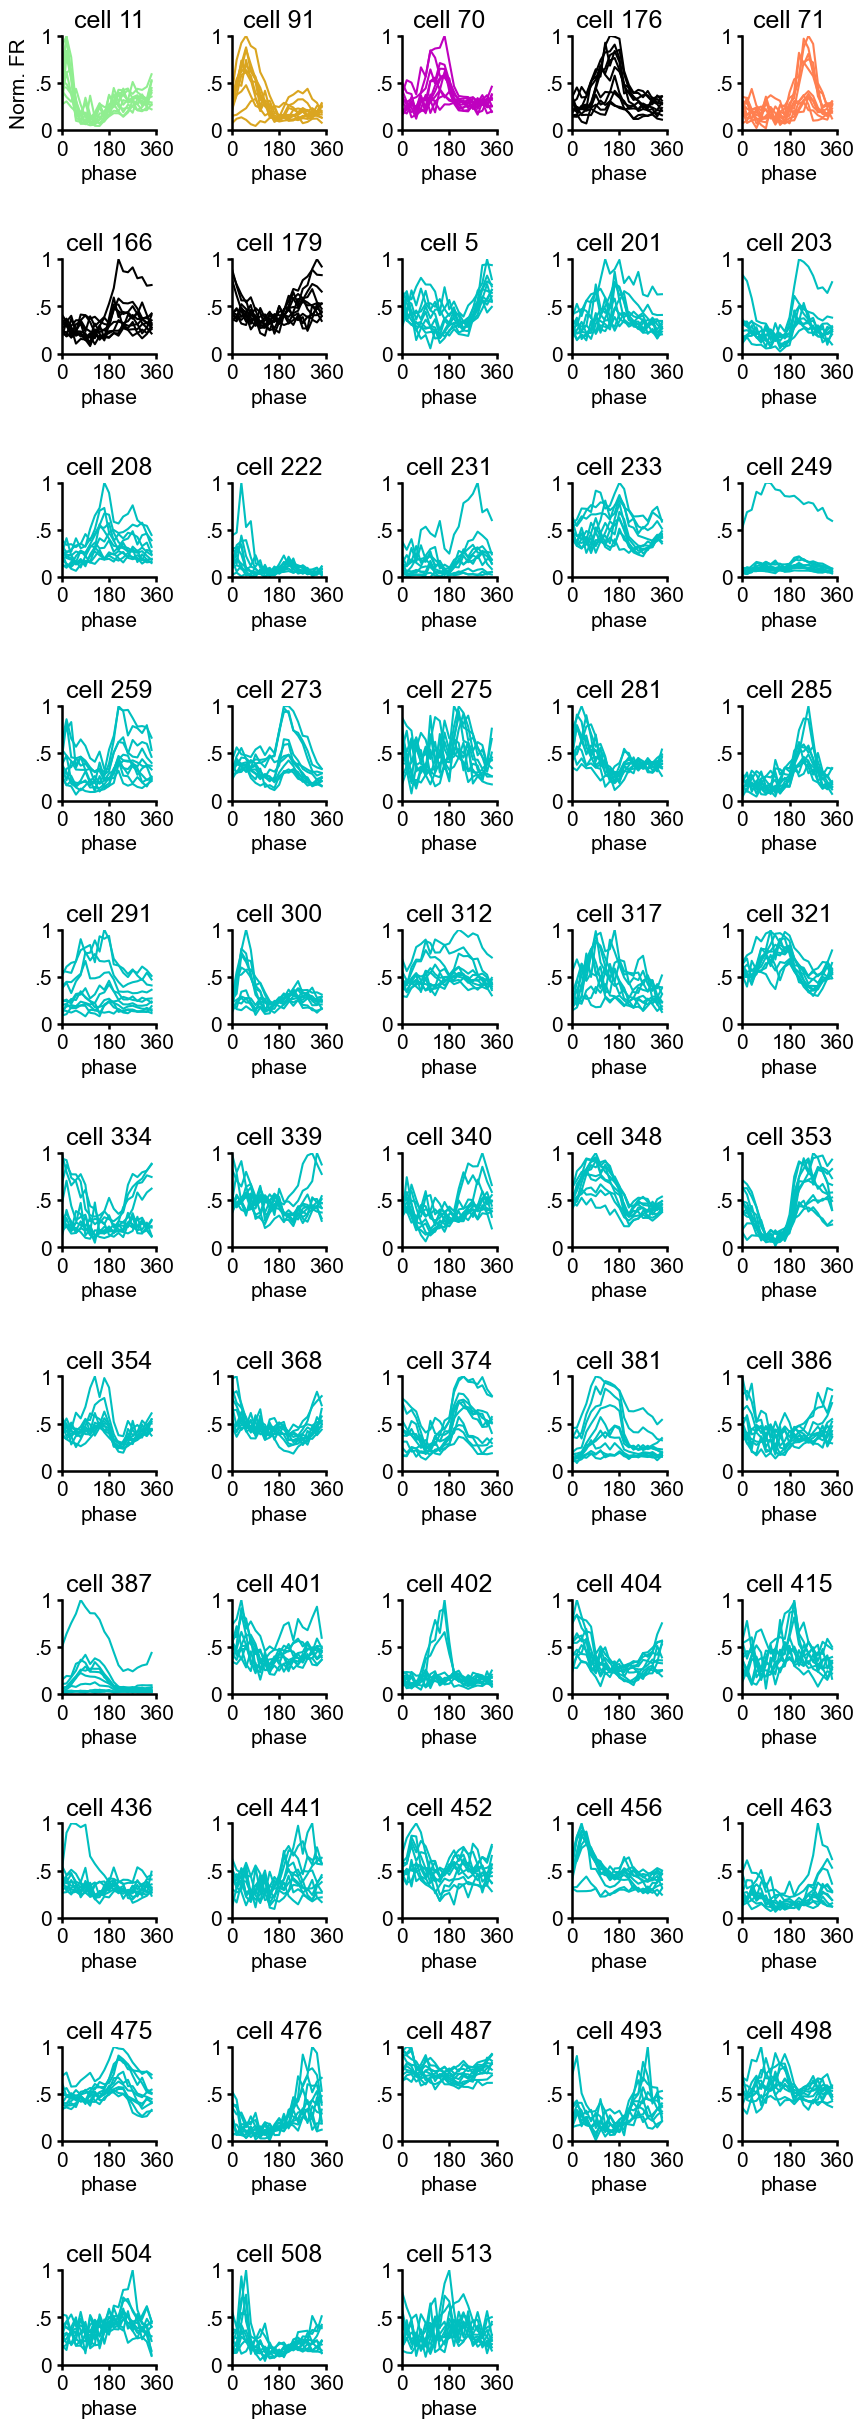

In [789]:
plt.figure(figsize = (10,30))
cells = [11,91,70,176,71,166,179,5,201,203,208,222,231,233,249,259,273,275,281,285,291,300,312,317,321,334,339,340,348,353,354,368,374,381,386,387,401,402,404,415,436,441,452,456,463,475,476,487,493,498,504,508,513]
colors = ['lightgreen','goldenrod','m','k','coral','k','k','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c','c']
phases = np.arange(0,360,18)
for cell_n, cell in enumerate(cells):
    plt.subplot(11,5,cell_n+1)
    for stim in range(all_phase_tuning_concat.shape[0]):
        plt.plot(phases,all_phase_tuning_concat[stim,:,cell]/np.max(all_phase_tuning_concat[:,:,cell]),color = colors[cell_n])
    #plt.plot(phases,tuning[0,:,cell]/np.max(tuning[:,:,cell]),color = 'k')
    plt.ylim(0,1)
    plt.xlim(0,360)
    plt.xticks([0,180,360])
    plt.yticks([0,.5,1], labels = ['0','.5','1'])
    plt.title('cell ' + str(cell))
    plt.xlabel('phase')
    if cell_n == 0:
        plt.ylabel('Norm. FR')
    PGanalysis.axis_fixer(ratio = 1, size = 15)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\all_spot_tuning_curve_example_cells_norm.pdf', bbox_inches = 'tight')

In [160]:
# Load the tuning curves for all cell-stim pairs
expt_list_tuning = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_tuning')
target_dir_tuning = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_tuning'

all_phase_tuning = []
for expt in expt_list_tuning:
    load_path = os.path.join(target_dir_tuning, expt)
    phase_tuning = np.load(load_path,allow_pickle = True)[0]
    all_phase_tuning.append(phase_tuning)

# concatenate tuning curves for all cells across experiments 
all_phase_tuning_concat = all_phase_tuning[0]
for tun in all_phase_tuning[1:]:
    all_phase_tuning_concat = np.concatenate((all_phase_tuning_concat, tun), axis = 2)

In [161]:
# get the tuning curves for all significantly activating spots for all cells 
n_cells = all_phase_tuning_concat.shape[2]
all_responsive_spot_tuning_curves = []
for cell in range(n_cells):
    # pull out sp0ts that significantly activate the cell (a non-nan stimulation phase preference)
    responsive_spots = np.where(~np.isnan(stimulation_phase_preference[:,cell]))[0]
    if len(responsive_spots)>0:
        responsive_spot_tuning_curves = all_phase_tuning_concat[responsive_spots,:,cell]
        all_responsive_spot_tuning_curves.append(responsive_spot_tuning_curves)

In [162]:
# flatten the list so we have an n_cell_spot_pairs x n_bins matrix
all_responsive_spot_tuning_curves_flat = np.array([spot for cell in all_responsive_spot_tuning_curves for spot in cell])
all_stim_tuning_ravel_norm = np.empty_like(all_responsive_spot_tuning_curves_flat)
# normalize the tuning curves
for curve_idx, curve in enumerate(all_responsive_spot_tuning_curves_flat):
    all_stim_tuning_ravel_norm[curve_idx,:] = curve/np.max(curve)

meta NOT subset; don't know how to subset; dropped


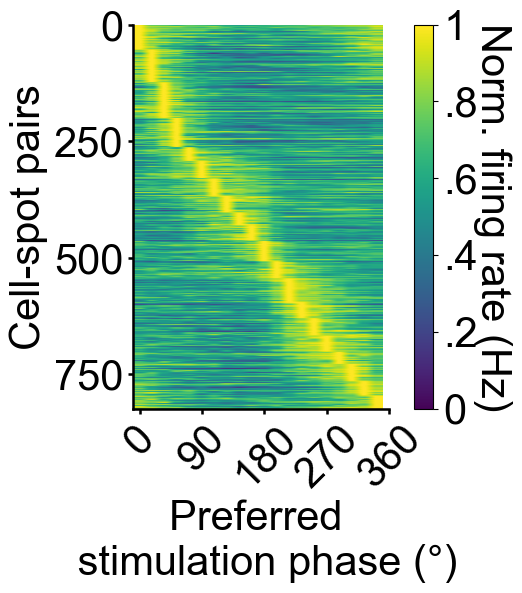

In [819]:
# plot the sorted tuning curves 
idx = np.argsort(np.argmax(all_stim_tuning_ravel_norm,1))
fig = plt.imshow(all_stim_tuning_ravel_norm[idx],aspect = 'auto')
plt.xticks(np.arange(0,25,5), labels = [str(x) for x in np.arange(0,450,90)], rotation = 45)
plt.clim(0,1)
plt.xlabel('Preferred \n stimulation phase (°)')
plt.ylabel('Cell-spot pairs')
ax = plt.gca()
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks([0,.2,.4,.6,.8,1])
cbar.ax.set_yticklabels(['0', '.2','.4','.6','.8','1'])
cbar.ax.set_ylabel('Norm. firing rate (Hz)', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\all_spot_tuning_population.pdf', bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


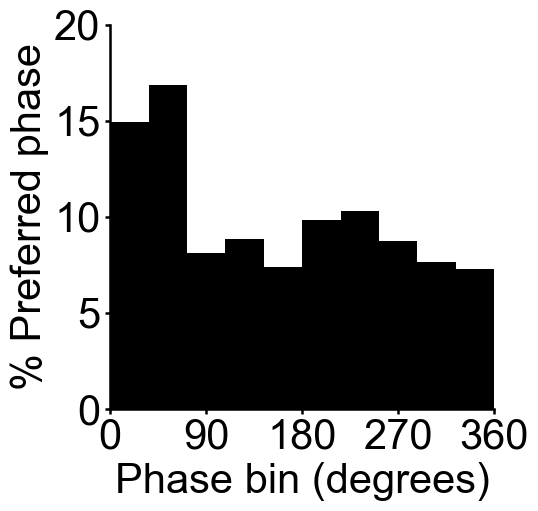

In [267]:
phases = np.arange(0,378,18)
phases_10bins = np.arange(0,396,36)
pref_phases = phases[np.argmax(all_stim_tuning_ravel_norm,1)]
hist_pref = np.histogram(pref_phases, bins = phases_10bins)
plt.bar(np.arange(0,360,36), (hist_pref[0]/np.sum(hist_pref[0]))*100, width = 36, color = 'k', align = 'edge')
plt.xlim(0,360)
plt.ylim(0,20)
plt.xticks([0,90,180,270,360])
plt.ylabel('% Preferred phase')
plt.xlabel('Phase bin (degrees)')
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_tuning_hist.pdf', bbox_inches = 'tight')

In [268]:
# calculate the phase tuning index
ori_idx = np.empty((all_phase_tuning_concat.shape[0], all_phase_tuning_concat.shape[2]))
for cell in range(all_phase_tuning_concat.shape[2]):
    for stim in range(all_phase_tuning_concat.shape[0]):
        ori_idx[stim,cell] = (np.max(all_phase_tuning_concat[stim,:,cell])-np.min(all_phase_tuning_concat[stim,:,cell]))/(np.max(all_phase_tuning_concat[stim,:,cell]))

In [269]:
# get the phase tuning index only for significantly activated cell-spot pairs 
# also get the phase tuning index for responses to the blank stimulus 
# calculate the difference between the tuning index for each significantly activated cell-spot pair and the blank 
stimulation_phase_preference = concat_dict['stimulation_phase_preference']
ori_idx_all_responsive = []
ori_idx_all_diff = []
for cell in range(all_phase_tuning_concat.shape[2]):
    ori_idx_resp = ori_idx[np.where(~np.isnan(stimulation_phase_preference[:,cell]))[0],cell]
    ori_idx_blank = ori_idx[0,cell]
    if len(ori_idx_resp)>0:
        ori_idx_all_responsive.append(list(ori_idx_resp))
        ori_idx_all_diff.append(ori_idx_resp - ori_idx_blank)
ori_idx_all_responsive_PCx = [cell for cells in ori_idx_all_responsive for cell in cells]
ori_idx_all_responsive_diff = [cell for cells in ori_idx_all_diff for cell in cells]

meta NOT subset; don't know how to subset; dropped


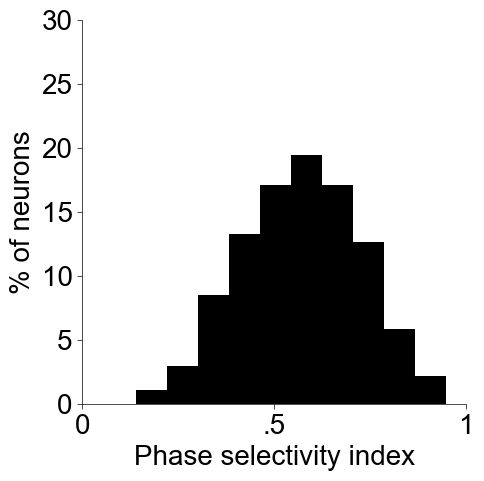

In [167]:
PCx_ori = np.histogram(ori_idx_all_responsive_PCx)
#PCx_ori_blank = np.histogram(ori_idx_all_responsive_diff)
plt.bar(PCx_ori[1][0:-1], (PCx_ori[0]/np.sum(PCx_ori[0]))*100, width = PCx_ori[1][1]-PCx_ori[1][0], color = 'k')
plt.ylim(0,30)
plt.xlim(0,1)
plt.ylabel('% of neurons')
plt.xlabel('Phase selectivity index')
plt.xticks([0,.5,1], labels = ['0','.5','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)
scipy.stats.ttest_1samp(ori_idx_all_responsive_diff, 0)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_selectivity_index.pdf', bbox_inches = 'tight')

In [168]:
n_cells = stimulation_phase_preference.shape[1]
mean_max_bin_plot = []
std_max_bin_plot = []
mean_max_bin_all = []
all_max_phases = []
all_max_phases_plot = []
cell_IDs = []
for cell in range(n_cells):
    responsive_spots = np.where(~np.isnan(stimulation_phase_preference[:,cell]))[0]
    if len(responsive_spots)>0:
        responsive_spot_tuning_curves = all_phase_tuning_concat[responsive_spots,:,cell]
        # get the index of the max response for each tuning curve
        responsive_spot_tuning_max_idx = np.argmax(responsive_spot_tuning_curves,1)
        responsive_spot_tuning_max_phase = phases[responsive_spot_tuning_max_idx]
        all_max_phases.append(responsive_spot_tuning_max_phase)
        mean_max_bin = scipy.stats.circmean(responsive_spot_tuning_max_phase, low = 0, high = 360)
        mean_max_bin_all.append(mean_max_bin)
        if len(responsive_spots)>2:
            all_max_phases_plot.append(responsive_spot_tuning_max_phase)
            mean_max_bin_plot.append(mean_max_bin)
            std_max_bin = scipy.stats.circstd(responsive_spot_tuning_max_phase, low = 0, high = 360)
            std_max_bin_plot.append(std_max_bin)
            cell_IDs.append(cell)
sort_indices = np.argsort(mean_max_bin_plot).astype(int)

meta NOT subset; don't know how to subset; dropped


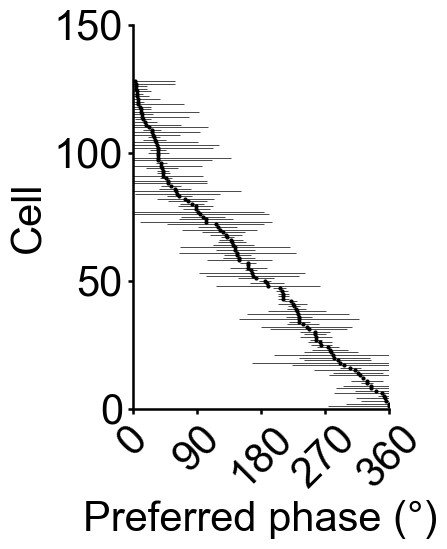

In [271]:
# For cells that respond to more than two spots, plot the mean and standard deviation of preferred phase
plt.errorbar(np.array(mean_max_bin_plot)[sort_indices], np.flipud(np.arange(1,len(mean_max_bin_plot)+1)), xerr = np.array(std_max_bin_plot)[sort_indices], fmt = 'ko', markersize = 2, linewidth = .5)
# cells = [11,91,70,71,5]
# colors = ['lightgreen','goldenrod','m','coral','c']
# for cell_n, cell in enumerate(cells):
#     plot_idx = np.where(sort_indices == cell)[0]
#     plt.plot(plot_idx, np.array(mean_max_bin_plot)[cell],'o', color = colors[cell_n])
plt.xlim(0,360)
plt.ylim(0,150)
plt.xticks([0,90,180,270,360], rotation = 45)
plt.ylabel('Cell')
plt.xlabel('Preferred phase (°)')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\preferred_tuning_std_sorted.pdf', bbox_inches = 'tight')

In [272]:
# perform 1000 bootstrapped iterations 
n_iters = 1000
# flatten th nested list of preferred phases for each cell 
all_max_phases_flat = [phase for phases in all_max_phases_plot for phase in phases]
bootstrapped_stds = np.empty(n_iters)
for iteration in range(n_iters):
    random.seed(42)
    new_shuffled_std = []
    # shuffle the flattened list of preferred phases 
    random.shuffle(all_max_phases_flat)
    idx = 0
    # for each cell, randomly sample preferred phases from the shuffled array, keeping the dimensions of each list constant
    for cell in all_max_phases_plot:
        grab_n = len(cell)
        # compute the standard deviation of the randomly sampled preferred phases 
        new_shuffled_std.append(scipy.stats.circstd(all_max_phases_flat[idx:idx+grab_n]))
        idx += grab_n
    # for each iteration, save the mean of standard deviations across the population 
    bootstrapped_stds[iteration] = np.mean(np.degrees(new_shuffled_std))

meta NOT subset; don't know how to subset; dropped


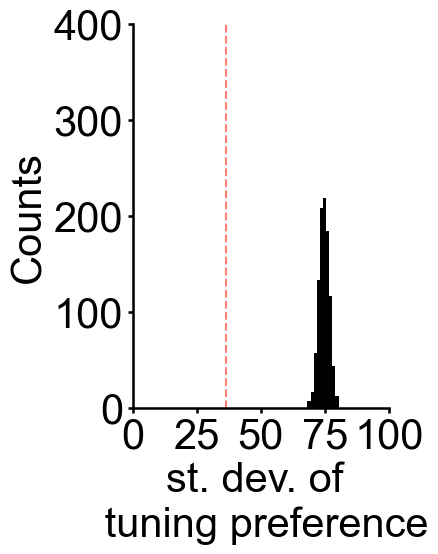

In [273]:
# plot a histogram of the mean standard deviations across 1000 iterations of randomly shuffled preferred phases
# additionally, plot the observed mean 
plt.hist(bootstrapped_stds, color = 'k')
plt.xlim(0,100)
plt.ylim(0,400)
std_mean_observed = np.mean(std_max_bin_plot)
plt.plot([std_mean_observed, std_mean_observed], [0,400], linestyle = '--', color = 'salmon')
plt.xlabel('st. dev. of \n tuning preference')
plt.ylabel('Counts')
plt.xticks(np.arange(0,125,25))
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\preferred_tuning_std_shuffle_control.pdf', bbox_inches = 'tight')

In [172]:
print('mean std observed = ' + str(np.mean(std_max_bin_plot)))
CI = st.t.interval(alpha=0.95, df=len(std_max_bin_plot)-1, loc=np.mean(std_max_bin_plot), scale=st.sem(std_max_bin_plot)) 
print('95% confidence interval = ' + str(np.mean(std_max_bin_plot) - CI[0]))

mean std observed = 36.394517145271024
95% confidence interval = 4.872567803936391


In [173]:
print('mean std shuffled = ' + str(np.mean(bootstrapped_stds)))
CI = st.t.interval(alpha=0.95, df=len(bootstrapped_stds)-1, loc=np.mean(bootstrapped_stds), scale=st.sem(bootstrapped_stds)) 
print('95% confidence interval = ' + str(np.mean(bootstrapped_stds) - CI[0]))

mean std shuffled = 74.76354452513323
95% confidence interval = 0.1274461879824429


In [174]:
# The observed mean does not occur in the bootstrapped distribution. Therefore, we can say that p<.001
print('the observed mean occurs in the bootstrapped distribution ' + str(len(np.where(np.array(bootstrapped_stds)<std_mean_observed)[0])) + ' times')
print('from the bootstrapped analysis, p < .001')

the observed mean occurs in the bootstrapped distribution 0 times
from the bootstrapped analysis, p < .001


### Next, we can measure the correlations between tuning curves measured for significantly activating or significantly suppressing spots

In [283]:
all_activated_cell_tuning_corr = []
all_activated_cell_tuning_corr_shuff = []
for expt in all_phase_expts:
    all_activated_cell_tuning_corr.append(expt['tuning_curve_correlations']['activated_cells'])
    all_activated_cell_tuning_corr_shuff.append(expt['tuning_curve_correlations_shuff']['activated_cells'])

In [284]:
all_activated_cell_tuning_corr = phase_analysis.unravel_list(all_activated_cell_tuning_corr)
all_activated_cell_tuning_corr_shuff = phase_analysis.unravel_list(all_activated_cell_tuning_corr_shuff)

meta NOT subset; don't know how to subset; dropped


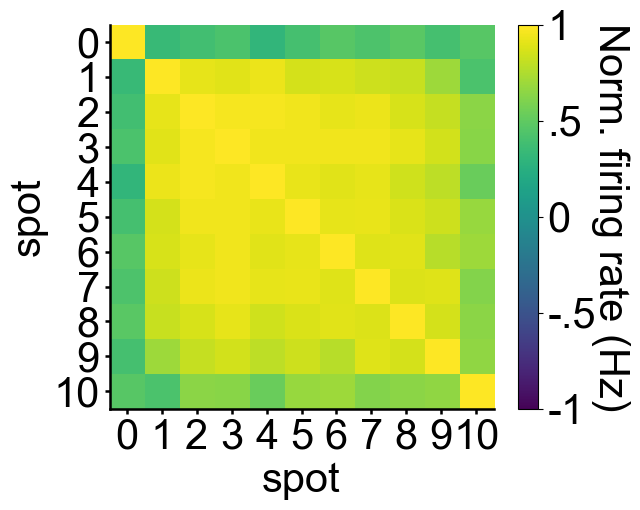

In [818]:
tuning_norm_example_cell = tuning[:,:,13]/np.max(tuning[:,:,13],1)[:,None]
plt.imshow(np.corrcoef(tuning_norm_example_cell))    
plt.xticks(np.arange(0,11));
plt.yticks(np.arange(0,11));
plt.xlabel('spot')
plt.ylabel('spot')
ax = plt.gca()
cbar = plt.colorbar()
plt.clim(-1,1)
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks([-1,-.5,0,.5,1])
cbar.ax.set_yticklabels(['-1', '-.5','0','.5','1'])
cbar.ax.set_ylabel('Norm. firing rate (Hz)', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\example_cell_tuning_correlations.pdf', bbox_inches = 'tight')

meta NOT subset; don't know how to subset; dropped


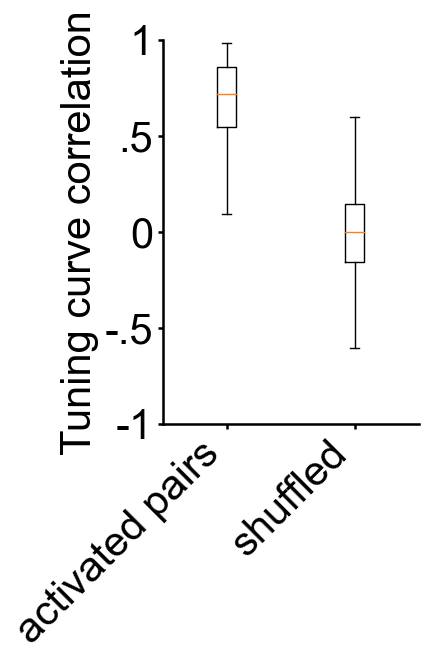

In [286]:
plt.boxplot([all_activated_cell_tuning_corr, all_activated_cell_tuning_corr_shuff], showfliers = False);
plt.ylim(-1,1)
plt.ylabel('Tuning curve correlation')
plt.xticks([1,2], labels = ['activated pairs', 'shuffled'], rotation = 45, ha = 'right')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.yticks([-1,-.5,0,.5,1], labels = ['-1', '-.5', '0', '.5', '1']);
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\tuning_curve_correlations.pdf', bbox_inches = 'tight')

In [45]:
scipy.stats.mannwhitneyu(all_activated_cell_tuning_corr, all_activated_cell_tuning_corr_shuff)

MannwhitneyuResult(statistic=104345.0, pvalue=0.0)

### Let's train a classifier using spot responses to see if we can decode response phase. 

In [291]:
# set the target directory for trial-by-trial spike counts over the 300ms response period for each experiment
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\population_analysis_data')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\population_analysis_data'

In [292]:
# bin the spike counts by the phase of OB stimulation. For each phase bin, we will use the first 15 trials of stimulation. 
all_phase_expts = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    binned_spike_counts = phase_analysis.bin_spike_counts_by_phase(phase_expt['trial_type_spike_counts'], phase_expt['bin_indices_all'], max_trial = 15)
    all_phase_expts.append(np.array(binned_spike_counts))

In [293]:
# set some useful parameters
n_spots = all_phase_expts[0].shape[0] # 11 spots (10 and 1 blank)
n_bins = all_phase_expts[0].shape[1] # 20 bins
n_trials = 15 # hard-coded, we will analyze the first 15 trials of each stimulation-phase for each spot

In [294]:
# concatenate cells across experiments for all spots (excluding the blank)
all_phase_expts_spot_cat = all_phase_expts[0][1:,:,:,:]
for expt in all_phase_expts[1:]:
    all_phase_expts_spot_cat = np.concatenate((all_phase_expts_spot_cat, expt[1:,:,:,:]), axis = 2)

In [295]:
# rearrange the axes so we end up with an n_bins x (n_spots x n_trials) x n_cells array. This gives us 150 trials per spot bin. 
all_phase_expts_spot_cat_arranged = np.moveaxis(all_phase_expts_spot_cat, (2,3), (3,2))
all_phase_expts_spot_cat_arranged = np.moveaxis(all_phase_expts_spot_cat_arranged, (0,1), (1,0))
all_phase_expts_spot_cat_reshaped = np.reshape(all_phase_expts_spot_cat_arranged,
                                               (all_phase_expts_spot_cat_arranged.shape[0],all_phase_expts_spot_cat_arranged.shape[1]*all_phase_expts_spot_cat_arranged.shape[2],all_phase_expts_spot_cat_arranged.shape[3]))

In [296]:
# reshape the training data in n_instances(150*20) x n_features(519). create a labels array with 150 trials per phase bin. 
train_data = np.reshape(all_phase_expts_spot_cat_reshaped, (all_phase_expts_spot_cat_reshaped.shape[0]*all_phase_expts_spot_cat_reshaped.shape[1],all_phase_expts_spot_cat_reshaped.shape[2]))
labels = np.repeat(np.arange(all_phase_expts_spot_cat_reshaped.shape[0]),all_phase_expts_spot_cat_reshaped.shape[1])

In [297]:
# Now, let's train an svm classifier using this data 
X_train = train_data
y_train = labels 
svm_clf = SVC(kernel = 'linear')

# train and test the classifier using 5-fold cross-validation
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx = confusion_matrix(y_train, y_train_pred)

# to get the % accuracy, divide the matrix by the number of trials 
row_sums = conf_mx.sum(axis = 1, keepdims = True)
conf_mx = conf_mx/row_sums

meta NOT subset; don't know how to subset; dropped


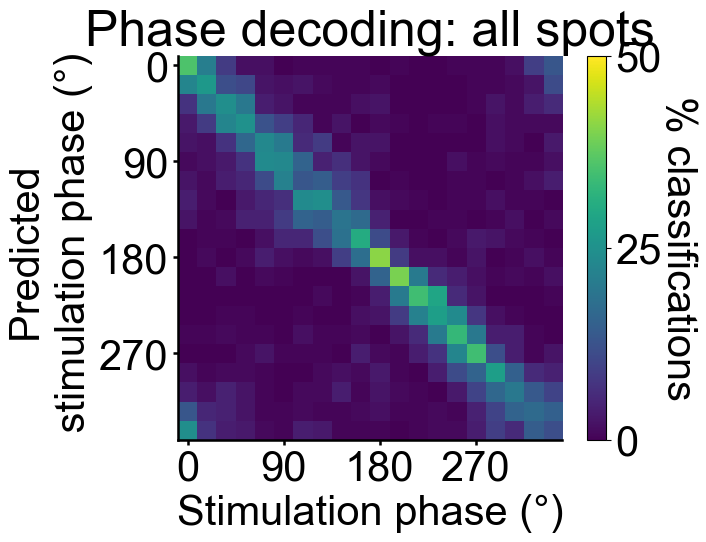

In [298]:
# plot the phase classification accuracy for spot stimulation
plt.imshow(conf_mx)
plt.title('Phase decoding: all spots')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_decoding_all_spots.pdf', bbox_inches = 'tight')

### Next, we will train a classifier using the blank condition to see how breathing alone affects firing rates

In [299]:
# Concatenate all of the cell responses in the blank condition (spot 0)
spot = 0
all_phase_expts_spot_cat_blank = all_phase_expts[0][spot,:,:,:]
for expt in all_phase_expts[1:]:
    all_phase_expts_spot_cat_blank = np.concatenate((all_phase_expts_spot_cat_blank, expt[spot,:,:,:]), axis = 1)
    
# rearrange and reshape the matrix, get phase labels for each trial
trial_type_phase_binned_spike_counts_move = np.moveaxis(all_phase_expts_spot_cat_blank, (0,1), (1,0))
spike_counts_reshaped, labels, stim_idxs = PGanalysis.spike_shaper_2d(trial_type_phase_binned_spike_counts_move)

# Train and test the classifier using 5-fold cross-validation
X_train = spike_counts_reshaped
y_train = labels 
svm_clf = SVC(kernel = 'linear')
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx_blank = confusion_matrix(y_train, y_train_pred)

# divide by the number of trials in the corresponding class
row_sums_blank = conf_mx_blank.sum(axis = 1, keepdims = True)
conf_mx_blank = conf_mx_blank/row_sums_blank

meta NOT subset; don't know how to subset; dropped


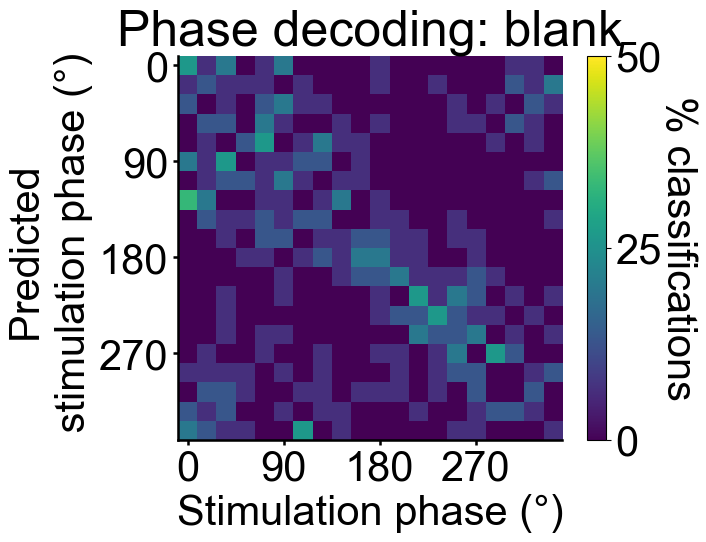

In [300]:
# plot the phase classification accuracy for blank trials
plt.imshow(conf_mx_blank)
plt.title('Phase decoding: blank')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_decoding_blank.pdf', bbox_inches = 'tight')

### Finally, to get chance performance, randomly shuffle the labels

In [58]:
# Now, as a control, let's train a set of classifiers using randomly shuffled labels
random.seed(42)
n_iters = 100
conf_mx_rnd_shuf_iters = np.empty((n_iters,n_bins,n_bins)) 
for iter_ in range(n_iters):
    X_train = train_data
    random_labels = np.repeat(np.arange(all_phase_expts_spot_cat_reshaped.shape[0]),all_phase_expts_spot_cat_reshaped.shape[1])
    random.shuffle(random_labels)
    y_train = random_labels

    # train and test the classifier using 5-fold cross-validation
    svm_clf = SVC(kernel = 'linear')
    y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
    conf_mx_rnd_shuf = confusion_matrix(y_train, y_train_pred)

    # to get the % accuracy, divide the matrix by the number of trials 
    row_sums_rnd_shuf = conf_mx_rnd_shuf.sum(axis = 1, keepdims = True)
    conf_mx_rnd_shuf = conf_mx_rnd_shuf/row_sums_rnd_shuf
    
    conf_mx_rnd_shuf_iters[iter_,:,:] = conf_mx_rnd_shuf

meta NOT subset; don't know how to subset; dropped


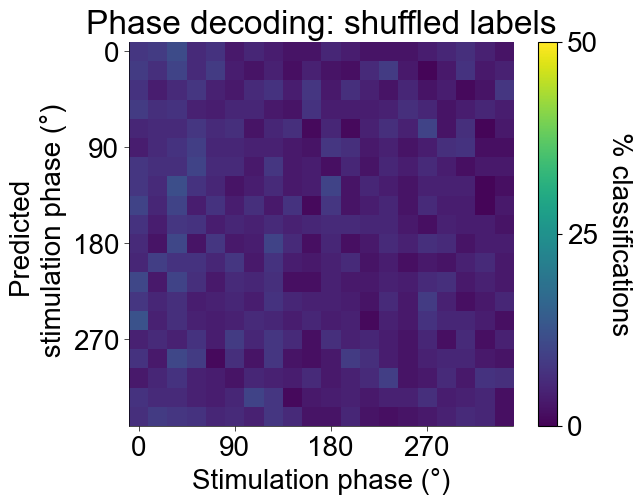

In [59]:
# plot an instance of the shuffled classifier 
plt.imshow(conf_mx_rnd_shuf)
plt.title('Phase decoding: shuffled labels')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')


plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_decoding_shuffle.pdf', bbox_inches = 'tight')

### Next, let's plot classifier performance as a function of bin distance from the correct label

In [301]:
# Here, we will shift each row of the matrix so that the correct bin is centered.
t = np.arange(10,-10,-1)
rolled_mat = np.zeros_like(conf_mx)
rolled_mat_blank = np.zeros_like(conf_mx_blank)
rolled_mat_rnd_shuf = np.zeros_like(conf_mx_rnd_shuf_iters)
for roll_n, roll in enumerate(t):
    rolled_mat[roll_n,:] = np.roll(conf_mx[roll_n,:],roll)
    rolled_mat_blank[roll_n,:] = np.roll(conf_mx_blank[roll_n,:],roll)
    rolled_mat_rnd_shuf[:,roll_n,:] = np.roll(conf_mx_rnd_shuf_iters[:,roll_n,:],roll)

In [302]:
# get the mean and 95% confidence interval from shuffled classifiers
rolled_mat_rnd_shuf_mean = np.mean(rolled_mat_rnd_shuf,1)
data = rolled_mat_rnd_shuf_mean
t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
CI = (t[1]-np.mean(data))

meta NOT subset; don't know how to subset; dropped


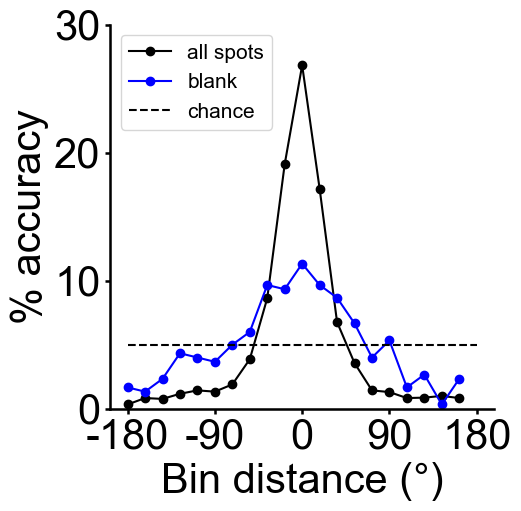

In [304]:
# Plot mean classifier accuracy as a function of distance from the correct bin. 
plt.plot(np.mean(rolled_mat,0),'-ko', label = 'all spots')
plt.plot(np.mean(rolled_mat_blank,0),'-bo', label = 'blank')
rolled_mat_rnd_shuf_mean = np.mean(rolled_mat_rnd_shuf,0)
#plt.errorbar(np.arange(20),np.mean(rolled_mat_rnd_shuf_mean, 0), yerr = CI, color = 'k', linewidth = .5)
plt.ylim(0,.3)
plt.plot([0,20],[1/20, 1/20], 'k--', label = 'chance')
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
plt.legend(loc = 'upper left', fontsize = 15)
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_decoding_comparison_allspots_blank.pdf', bbox_inches = 'tight')

### Let's compare individual spot classifier accuracy to blank accuracy.

In [226]:
# For each spot, concantenate cell responses from each experiment
all_rolled_mat_single_spot = np.empty((n_spots-1,n_bins))
all_conf_mx_single_spot = np.empty((n_spots-1,n_bins,n_bins))
for spot in range(1,n_spots):
    all_phase_expts_spot_cat = all_phase_expts[0][spot,:,:,:]
    for expt in all_phase_expts[1:]:
        all_phase_expts_spot_cat = np.concatenate((all_phase_expts_spot_cat, expt[spot,:,:,:]), axis = 1)
    
    # rearrange and reshape the matrix to get an n_instances x n_features matrix, get phase labels for each trial
    trial_type_phase_binned_spike_counts_move = np.moveaxis(all_phase_expts_spot_cat, (0,1), (1,0))
    spike_counts_reshaped, labels, stim_idxs = PGanalysis.spike_shaper_2d(trial_type_phase_binned_spike_counts_move)
    X_train = spike_counts_reshaped
    y_train = labels 
    
    # train the SVM classfier
    svm_clf = SVC(kernel = 'linear')
    y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
    conf_mx_single_spot = confusion_matrix(y_train, y_train_pred)
    conf_mx_single_spot = conf_mx_single_spot/trial_type_phase_binned_spike_counts_move.shape[2]
    all_conf_mx_single_spot[spot-1,:,:] = conf_mx_single_spot
    
    # roll the matrix to get accuracy as a function of distance from correct bin 
    t = np.arange(10,-10,-1)
    rolled_mat_single_spot = np.zeros_like(conf_mx_single_spot)
    for roll_n, roll in enumerate(t):
        rolled_mat_single_spot[roll_n,:] = np.roll(conf_mx_single_spot[roll_n,:],roll)
    
    # populate the matrix with accuracy values for each spot
    all_rolled_mat_single_spot[spot-1,:] = np.mean(rolled_mat_single_spot,0)

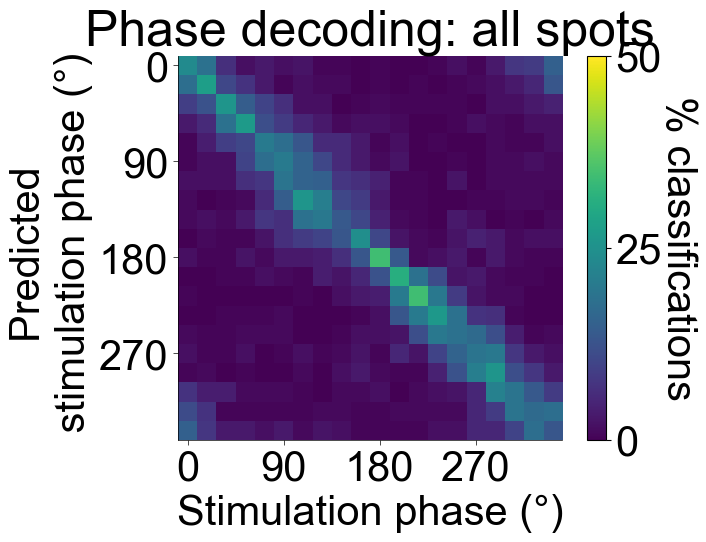

In [229]:
plt.imshow(np.mean(all_conf_mx_single_spot,0))
plt.title('Phase decoding: all spots')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 30)


meta NOT subset; don't know how to subset; dropped


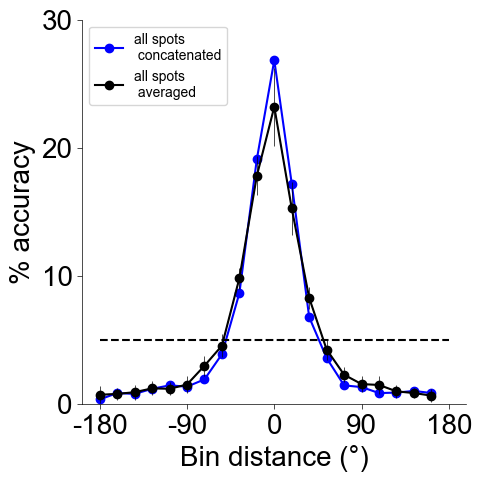

In [64]:
plt.plot(np.mean(rolled_mat, 0),'-bo', label = 'all spots \n concatenated')
plt.plot(np.mean(all_rolled_mat_single_spot, 0),'-ko', label = 'all spots \n averaged')

CI = []
for bin_ in range(20):
    data = all_rolled_mat_single_spot[:,bin_]
    t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    CI.append(t[1]-np.mean(data))
plt.errorbar(np.arange(20),np.mean(all_rolled_mat_single_spot, 0), yerr = CI, color = 'k', linewidth = .5)

plt.ylim(0,.3)
plt.plot([0,20],[1/20, 1/20], 'k--')
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
plt.legend(loc = 'upper left', fontsize = 10)
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_decoding_individual_spots_vs_all_spots.pdf', bbox_inches = 'tight')

### Let's test generalization performance across spots

In [239]:
# reshape the training data in n_instances(150*20) x n_features(519). create a labels array with 150 trials per phase bin. 
train_data = np.reshape(all_phase_expts_spot_cat_reshaped, (all_phase_expts_spot_cat_reshaped.shape[0]*all_phase_expts_spot_cat_reshaped.shape[1],all_phase_expts_spot_cat_reshaped.shape[2]))
labels = np.repeat(np.arange(all_phase_expts_spot_cat_reshaped.shape[0]),all_phase_expts_spot_cat_reshaped.shape[1])

In [240]:
# Here, we will use the same training data and labels as in the initial phase classifier. 
groups = []
for bin_ in range(n_bins):
    groups.append(np.repeat(np.arange(n_spots-1),n_trials))
groups = np.array([group for bin_ in groups for group in bin_])

In [241]:
# We will use GroupKFold to assess generalization performance. This allows us to split the training data into a set of training groups and a held-out group. 
from sklearn.model_selection import GroupKFold

# We will split the data into 10 different groups
group_kfold = GroupKFold(n_splits=n_spots-1)

# Save the 10 matrices that will be generated
generalize_conf_mx = np.empty((n_spots-1, n_bins, n_bins))
for i, (train_index, test_index) in enumerate(group_kfold.split(train_data, labels, groups)):
    
    # define the train and test sets 
    X_train = train_data[train_index,:]
    X_test = train_data[test_index,:]
    y_train = labels[train_index]
    y_test = labels[test_index]
    
    # train the SVM
    svm_clf = SVC(kernel = 'linear')
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    conf_mx = confusion_matrix(y_test, y_pred)
    row_sums = conf_mx.sum(axis = 1, keepdims = True)
    conf_mx = conf_mx/row_sums
    
    # save the output 
    generalize_conf_mx[i,:,:] = conf_mx

meta NOT subset; don't know how to subset; dropped


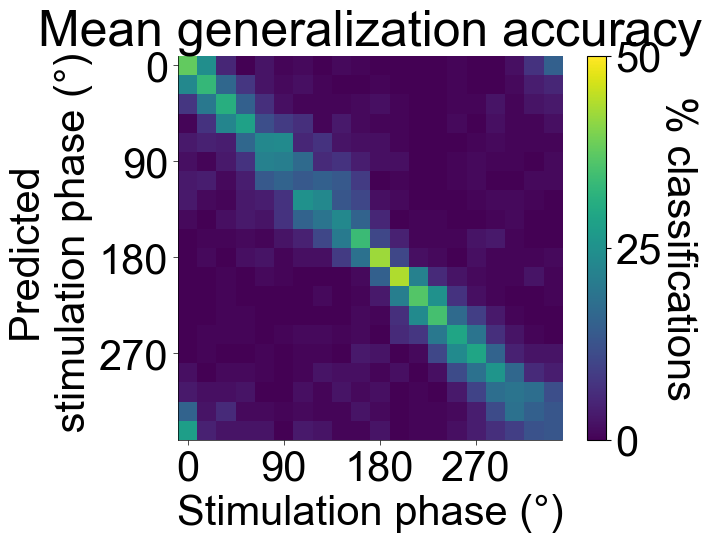

In [242]:
# plot the phase classification accuracy for spot stimulation
plt.imshow(np.mean(generalize_conf_mx,0))
plt.title('Mean generalization accuracy')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\mean_generalization_accuracy.pdf', bbox_inches = 'tight')

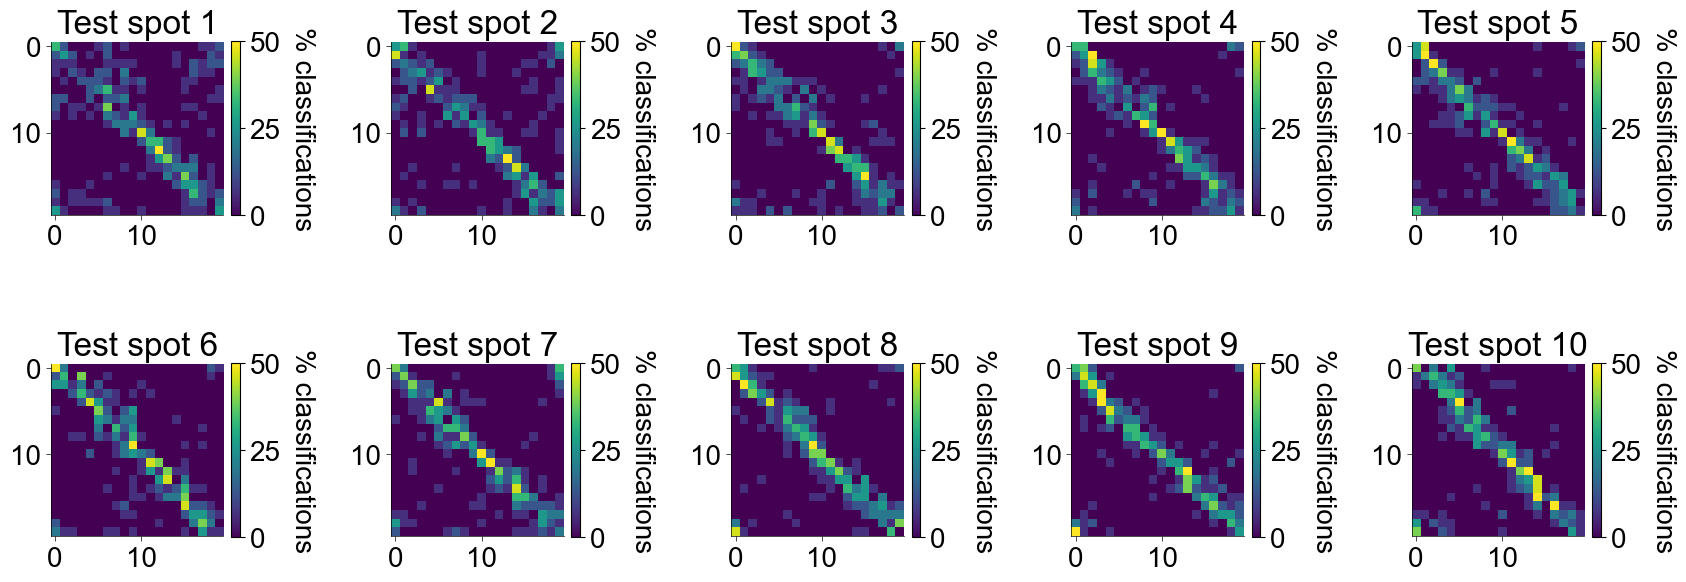

In [81]:
plt.figure(figsize = (20,7))
for mx_n, mx in enumerate(generalize_conf_mx):
    plt.subplot(2,5,mx_n+1)
    plt.imshow(mx)
    plt.clim(0,.5)
    ax = plt.gca()
    cbar = plt.colorbar(ticks = [0,.25,.5], fraction=0.046, pad=0.04)
    cbar.solids.set_edgecolor("face")
    cbar.ax.set_ylabel('% classifications', rotation = 270)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_yticklabels(['0','25','50'])
    plt.title('Test spot ' + str(mx_n+1))
    PGanalysis.axis_fixer(size = 20)

In [82]:
t = np.arange((n_spots-1),(n_spots-1)*-1,-1)
generalization_rolled_mats = np.empty((len(generalize_conf_mx), generalize_conf_mx[0].shape[0]))
rolled_mat = np.zeros_like(generalize_conf_mx[0])
for conf_mx_n, conf_mx in enumerate(generalize_conf_mx):
    for roll_n, roll in enumerate(t):
        rolled_mat[roll_n,:] = np.roll(conf_mx[roll_n,:],roll)
    generalization_rolled_mats[conf_mx_n, :] = np.mean(rolled_mat,0)

meta NOT subset; don't know how to subset; dropped


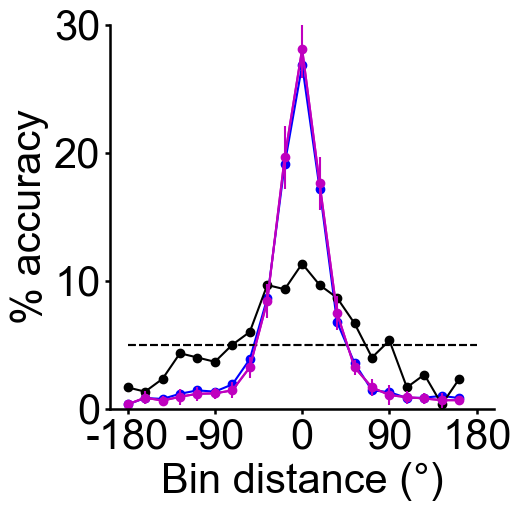

In [307]:
plt.plot(np.mean(rolled_mat,0),'-bo', label = 'all spots')
plt.plot(np.mean(rolled_mat_blank,0),'-ko', label = 'blank')
rolled_mat_rnd_shuf_mean = np.mean(rolled_mat_rnd_shuf,0)
#plt.errorbar(np.arange(20),np.mean(rolled_mat_rnd_shuf_mean, 0), yerr = CI, color = 'k', linewidth = .5)
plt.ylim(0,.3)
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
PGanalysis.axis_fixer(ratio = 1, size = 30)

plt.plot(np.mean(generalization_rolled_mats,0),'m-o',label = 'generalization')

CI = []
for bin_ in range(20):
    data = generalization_rolled_mats[:,bin_]
    t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    CI.append(t[1]-np.mean(data))
plt.errorbar(np.arange(20),np.mean(generalization_rolled_mats, 0), yerr = CI, color = 'm')

plt.ylim(0,.3)
plt.plot([0,20],[1/20, 1/20], 'k--')
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
plt.plot([0,20],[1/20, 1/20], 'k--', label = 'chance')
#plt.legend(loc = 'upper left', fontsize = 20)
#plt.legend(loc = 'upper left', fontsize = 10)
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_blank_generalization_decoding.pdf', bbox_inches = 'tight')

In [84]:
# Now, let's train an svm classifier using this data 
X_train = train_data
y_train = groups 
svm_clf = SVC(kernel = 'linear')

# train and test the classifier using 5-fold cross-validation
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx = confusion_matrix(y_train, y_train_pred)

# to get the % accuracy, divide the matrix by the number of trials 
row_sums = conf_mx.sum(axis = 1, keepdims = True)
conf_mx = conf_mx/row_sums

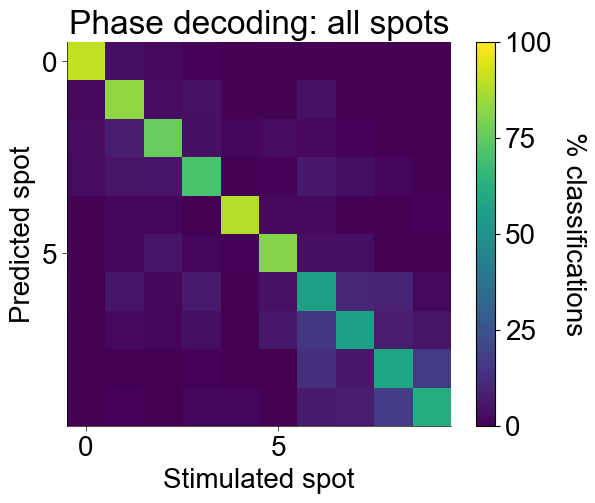

In [85]:
plt.imshow(conf_mx)
plt.title('Phase decoding: all spots')
plt.xticks(np.arange(0,10,5), labels = [str(x) for x in np.arange(0,10,5)])
plt.yticks(np.arange(0,10,5), labels = [str(x) for x in np.arange(0,10,5)])
plt.ylabel('Predicted spot')
plt.xlabel('Stimulated spot')

plt.clim(0,1)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5,.75,1])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50','75','100'])
PGanalysis.axis_fixer(size = 20)